<h2>Post Processing: Contrail Sweep Uncertainty</h2>
The ambient relative humidity is set to a value that allows a contrail to persist. When APCEMM knows that the contrail may persist, the results from EPM will be used as the inputs for the mature plume model (MPM). The MPM then runs until either the vast majority of ice crystals have subliminated, or the simulation time reaches the plume process time as specified in the input file (as is the case here). The contrail would otherwise persist for over 24 hours with these parameters.

<h4>Specifying Meteorological Conditions in APCEMM</h4>
To run APCEMM, the user must select at least one of "Use met input", "Impose moist layer depth", or "Impose lapse rate" in the Meteorology Menu. In this case, we have specified a supersaturated layer depth of 1000 meters. Imposing a moist layer depth will take precedent over imposing the lapse rate due to the conditions required to fulfill a specified depth.

<h4>Specifying Meteorological Conditions in APCEMM</h4>


In [1]:
#Import Libs and setup plotting settings
import os.path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#Functions that will be used for postprocessing
class apce_data_struct:
    def __init__(self, t, ds_t, icemass, h2omass, numparts):
        self.t = t
        self.ds_t = ds_t
        self.icemass = icemass
        self.h2omass = h2omass
        self.numparts = numparts
    
def read_apcemm_data(directory):
    t_mins = []
    ds_t = []
    ice_mass = []
    total_h2o_mass = []
    num_particles = []

    for file in sorted(os.listdir(directory)):
        if(file.startswith('ts_aerosol') and file.endswith('.nc')):
            file_path = os.path.join(directory,file)
            ds = xr.open_dataset(file_path, engine = "netcdf4", decode_times = False)
            ds_t.append(ds)
            tokens = file_path.split('.')
            mins = int(tokens[-2][-2:])
            hrs = int(tokens[-2][-4:-2])
            t_mins.append(hrs*60 + mins)

            ice_mass.append(ds["Ice Mass"])
            num_particles.append(ds["Number Ice Particles"])
            dx = abs(ds["x"][-1] - ds["x"][0])/len(ds["x"])
            dy = abs(ds["y"][-1] - ds["y"][0])/len(ds["y"])
            
            h2o_mass = np.sum(ds["H2O"]) * 1e6 / 6.022e23 * 0.018 * dx*dy + ds["Ice Mass"]
            total_h2o_mass.append(h2o_mass.values)
    return apce_data_struct(t_mins, ds_t, ice_mass, total_h2o_mass, num_particles)

def removeLow(arr, cutoff = 1e-3):
    func = lambda x: (x > cutoff) * x
    vfunc = np.vectorize(func)
    return vfunc(arr)

In [3]:
#Analysis for properly sorted results
from scipy.stats import mode
cases = 5
JOB_ID = str(324523)
variable = "SootRadius"

horz_diff = [15,48,82,116,150]

soot_radius = [1e-8,3e-8,5e-8,10e-8,20e-8]
soot_radius_dir = [0,0,0,0,0]

vert_diff_num = [0.15,1.6125,3.075,4.5375,6]
vert_diff_dir = [0,1,3,4,6]

k = 0

apce_data = read_apcemm_data('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+str(soot_radius_dir[k]))
t_len = len(apce_data.t)
t_all = np.zeros((cases,t_len))
VOD = np.zeros((cases,t_len))

VOD_case_avg = np.zeros(cases)
for k in range(cases):
    apce_data = read_apcemm_data('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+str(soot_radius_dir[k]))
    t = apce_data.t
    ds_t = apce_data.ds_t
    ice_mass = apce_data.icemass
    total_h2o_mass = apce_data.h2omass
    X, Y = np.meshgrid(ds_t[0]['x'], ds_t[0]['y'])

    for i in range(len(t)):
        t_all[k,i] = t[i]
        VOD[k,i] = np.max((ds_t[i]["Vertical optical depth"]))
        VOD_case_avg[k] = np.mean(VOD[k,:])

In [4]:
print((ds_t[100]["Vertical optical depth"]))

<xarray.DataArray 'Vertical optical depth' (x: 2048)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
  * x        (x) float32 -9.995e+04 -9.985e+04 ... 9.985e+04 9.995e+04
Attributes:
    units:      -
    long_name:  Vertically-integrated optical depth


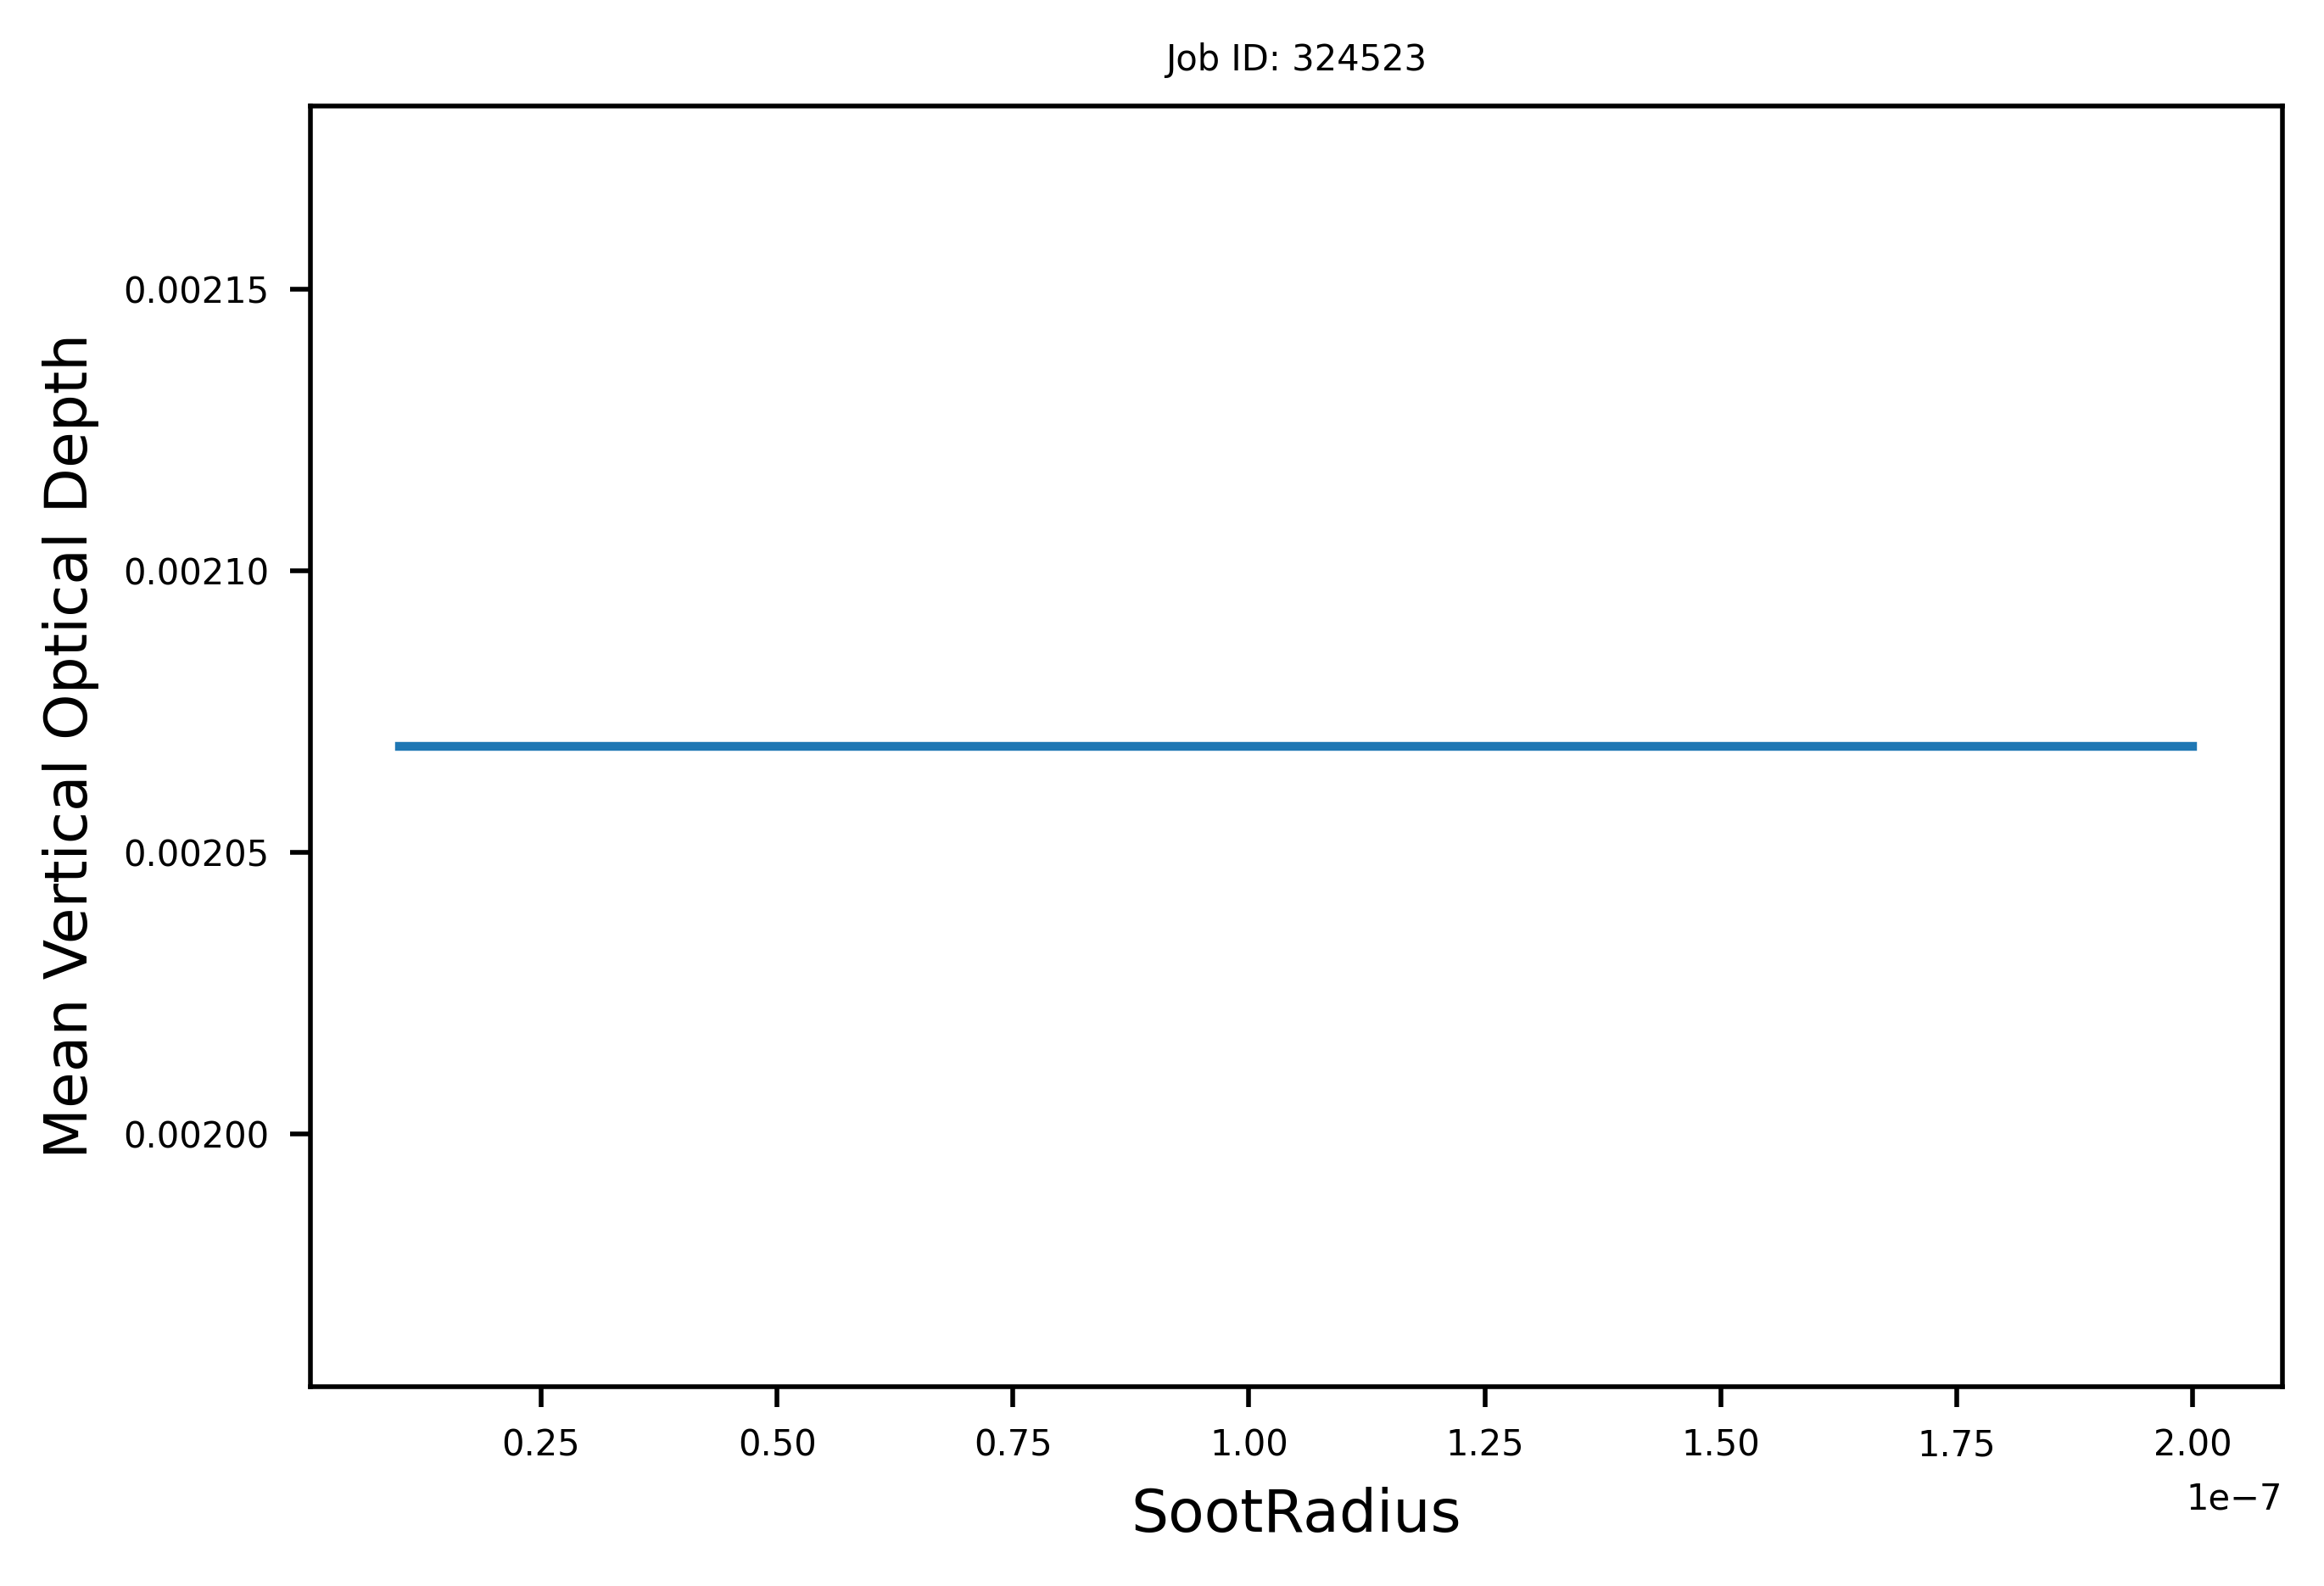

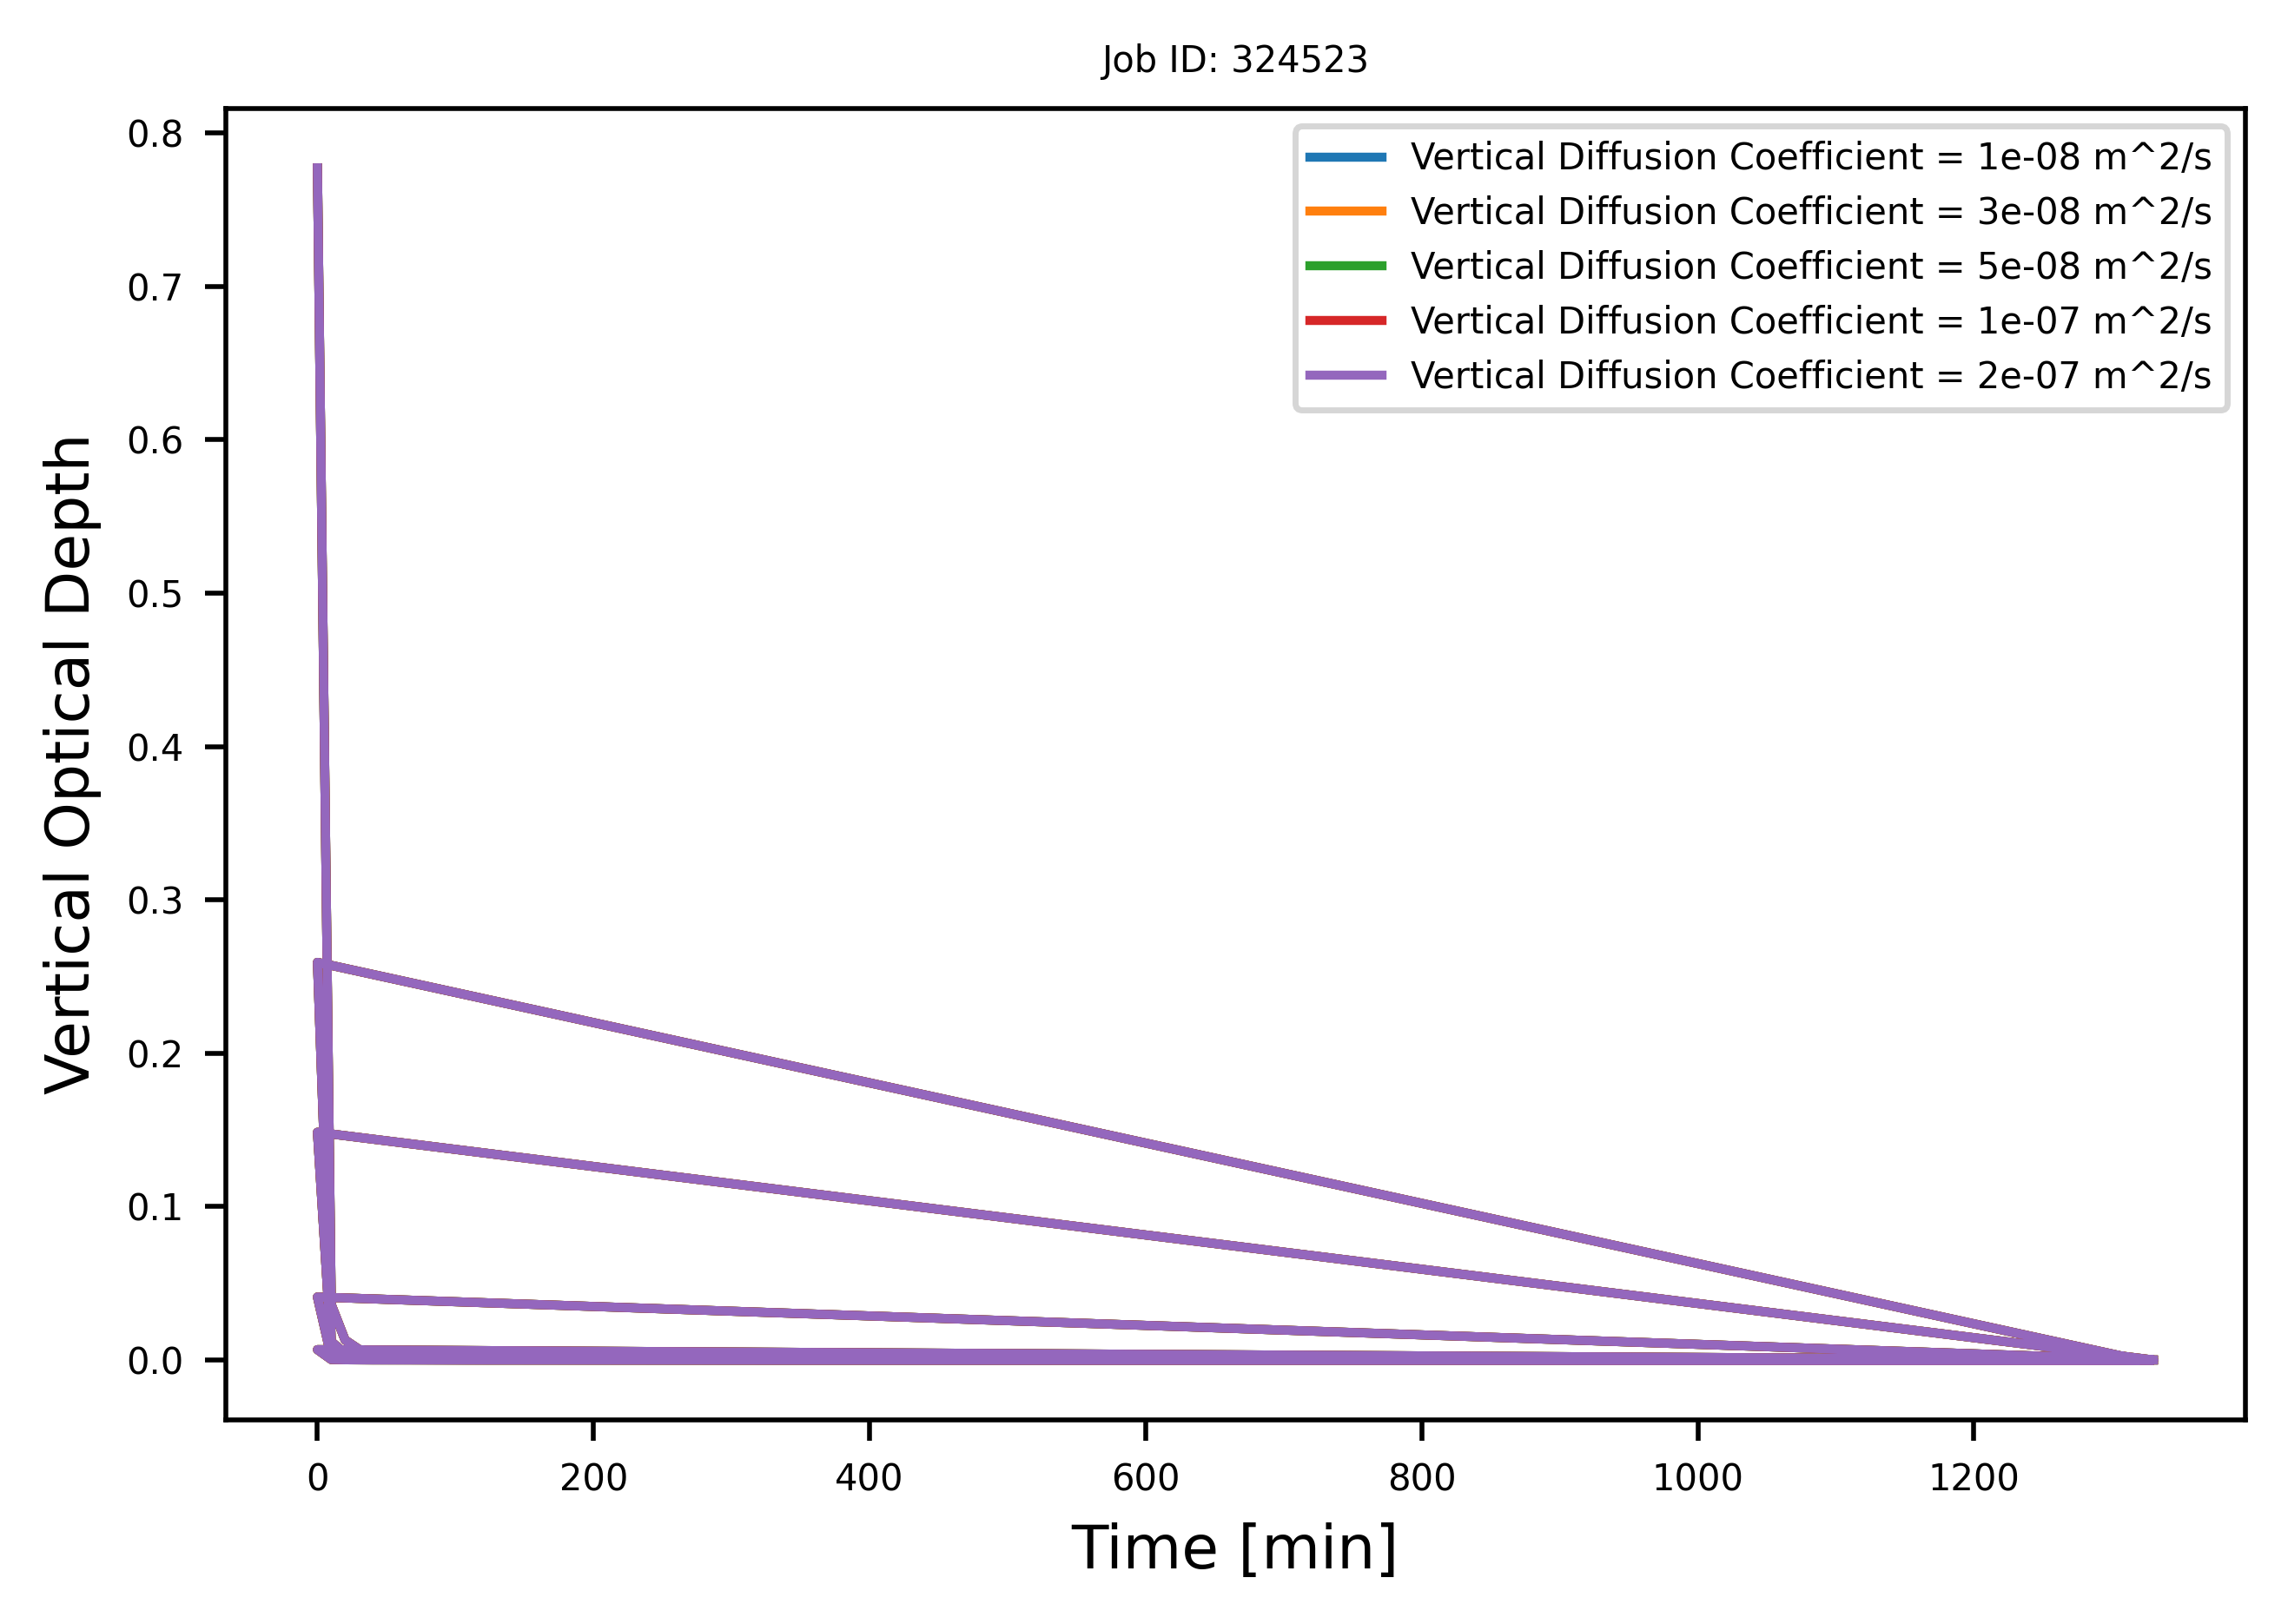

In [5]:
#Plotting for properly sorted results
fig, axes = plt.subplots(dpi=500)
axes.plot(soot_radius, VOD_case_avg)
axes.set_xlabel(variable)
axes.set_ylabel("Mean Vertical Optical Depth")
axes.set_title("Job ID: "+JOB_ID)
fig.savefig('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+variable+'_vs_OD')

fig2, axes2 = plt.subplots(dpi=500)

for k in range(cases):
    axes2.plot(t, VOD[k,:],label='Vertical Diffusion Coefficient = '+str(soot_radius[k])+' m^2/s')
    axes2.legend()
    axes2.set_title("Job ID: "+JOB_ID)

axes2.set_xlabel("Time [min]")
axes2.set_ylabel("Vertical Optical Depth")
fig2.savefig('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+str(soot_radius_dir[k])+'_time_vs_OD')

In [6]:
#Analysis for improperly sorted results

cases = 5
JOB_ID = str(324523)
variable = "SootRadius"
#soot_radius_dir = [15,48,82,116,150]
soot_radius = [1e-8,3e-8,5e-8,10e-8,20e-8]
soot_radius_dir = [0,0,0,0,0]
vert_diff_num = [0.15,1.6125,3.075,4.5375,6]
vert_diff_dir = [0,1,3,4,6]
wind_shear = [0,0.0035,0.007,0.0105,0.014]
k = 0

apce_data = read_apcemm_data('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+str(soot_radius_dir[k]))
t_len = len(apce_data.t)
t_all = np.zeros(t_len)
VOD = np.zeros(t_len)

split_result_array = int(t_len/5)
VOD_case_avg = np.zeros(cases)

t = apce_data.t
ds_t = apce_data.ds_t
ice_mass = apce_data.icemass
total_h2o_mass = apce_data.h2omass
X, Y = np.meshgrid(ds_t[0]['x'], ds_t[0]['y'])

for j in range(cases):
    for i in range(len(t)):
        VOD[i] = np.median(np.abs(ds_t[i]["Vertical optical depth"]))
        VOD_case_avg[j] = np.mean(VOD[j*split_result_array :(j+1)*split_result_array])

VOD = VOD/np.max(VOD)

Stored 'VOD_cases' (ndarray)
Stored 't' (list)


Text(0, 0.5, 'Vertical Optical Depth')

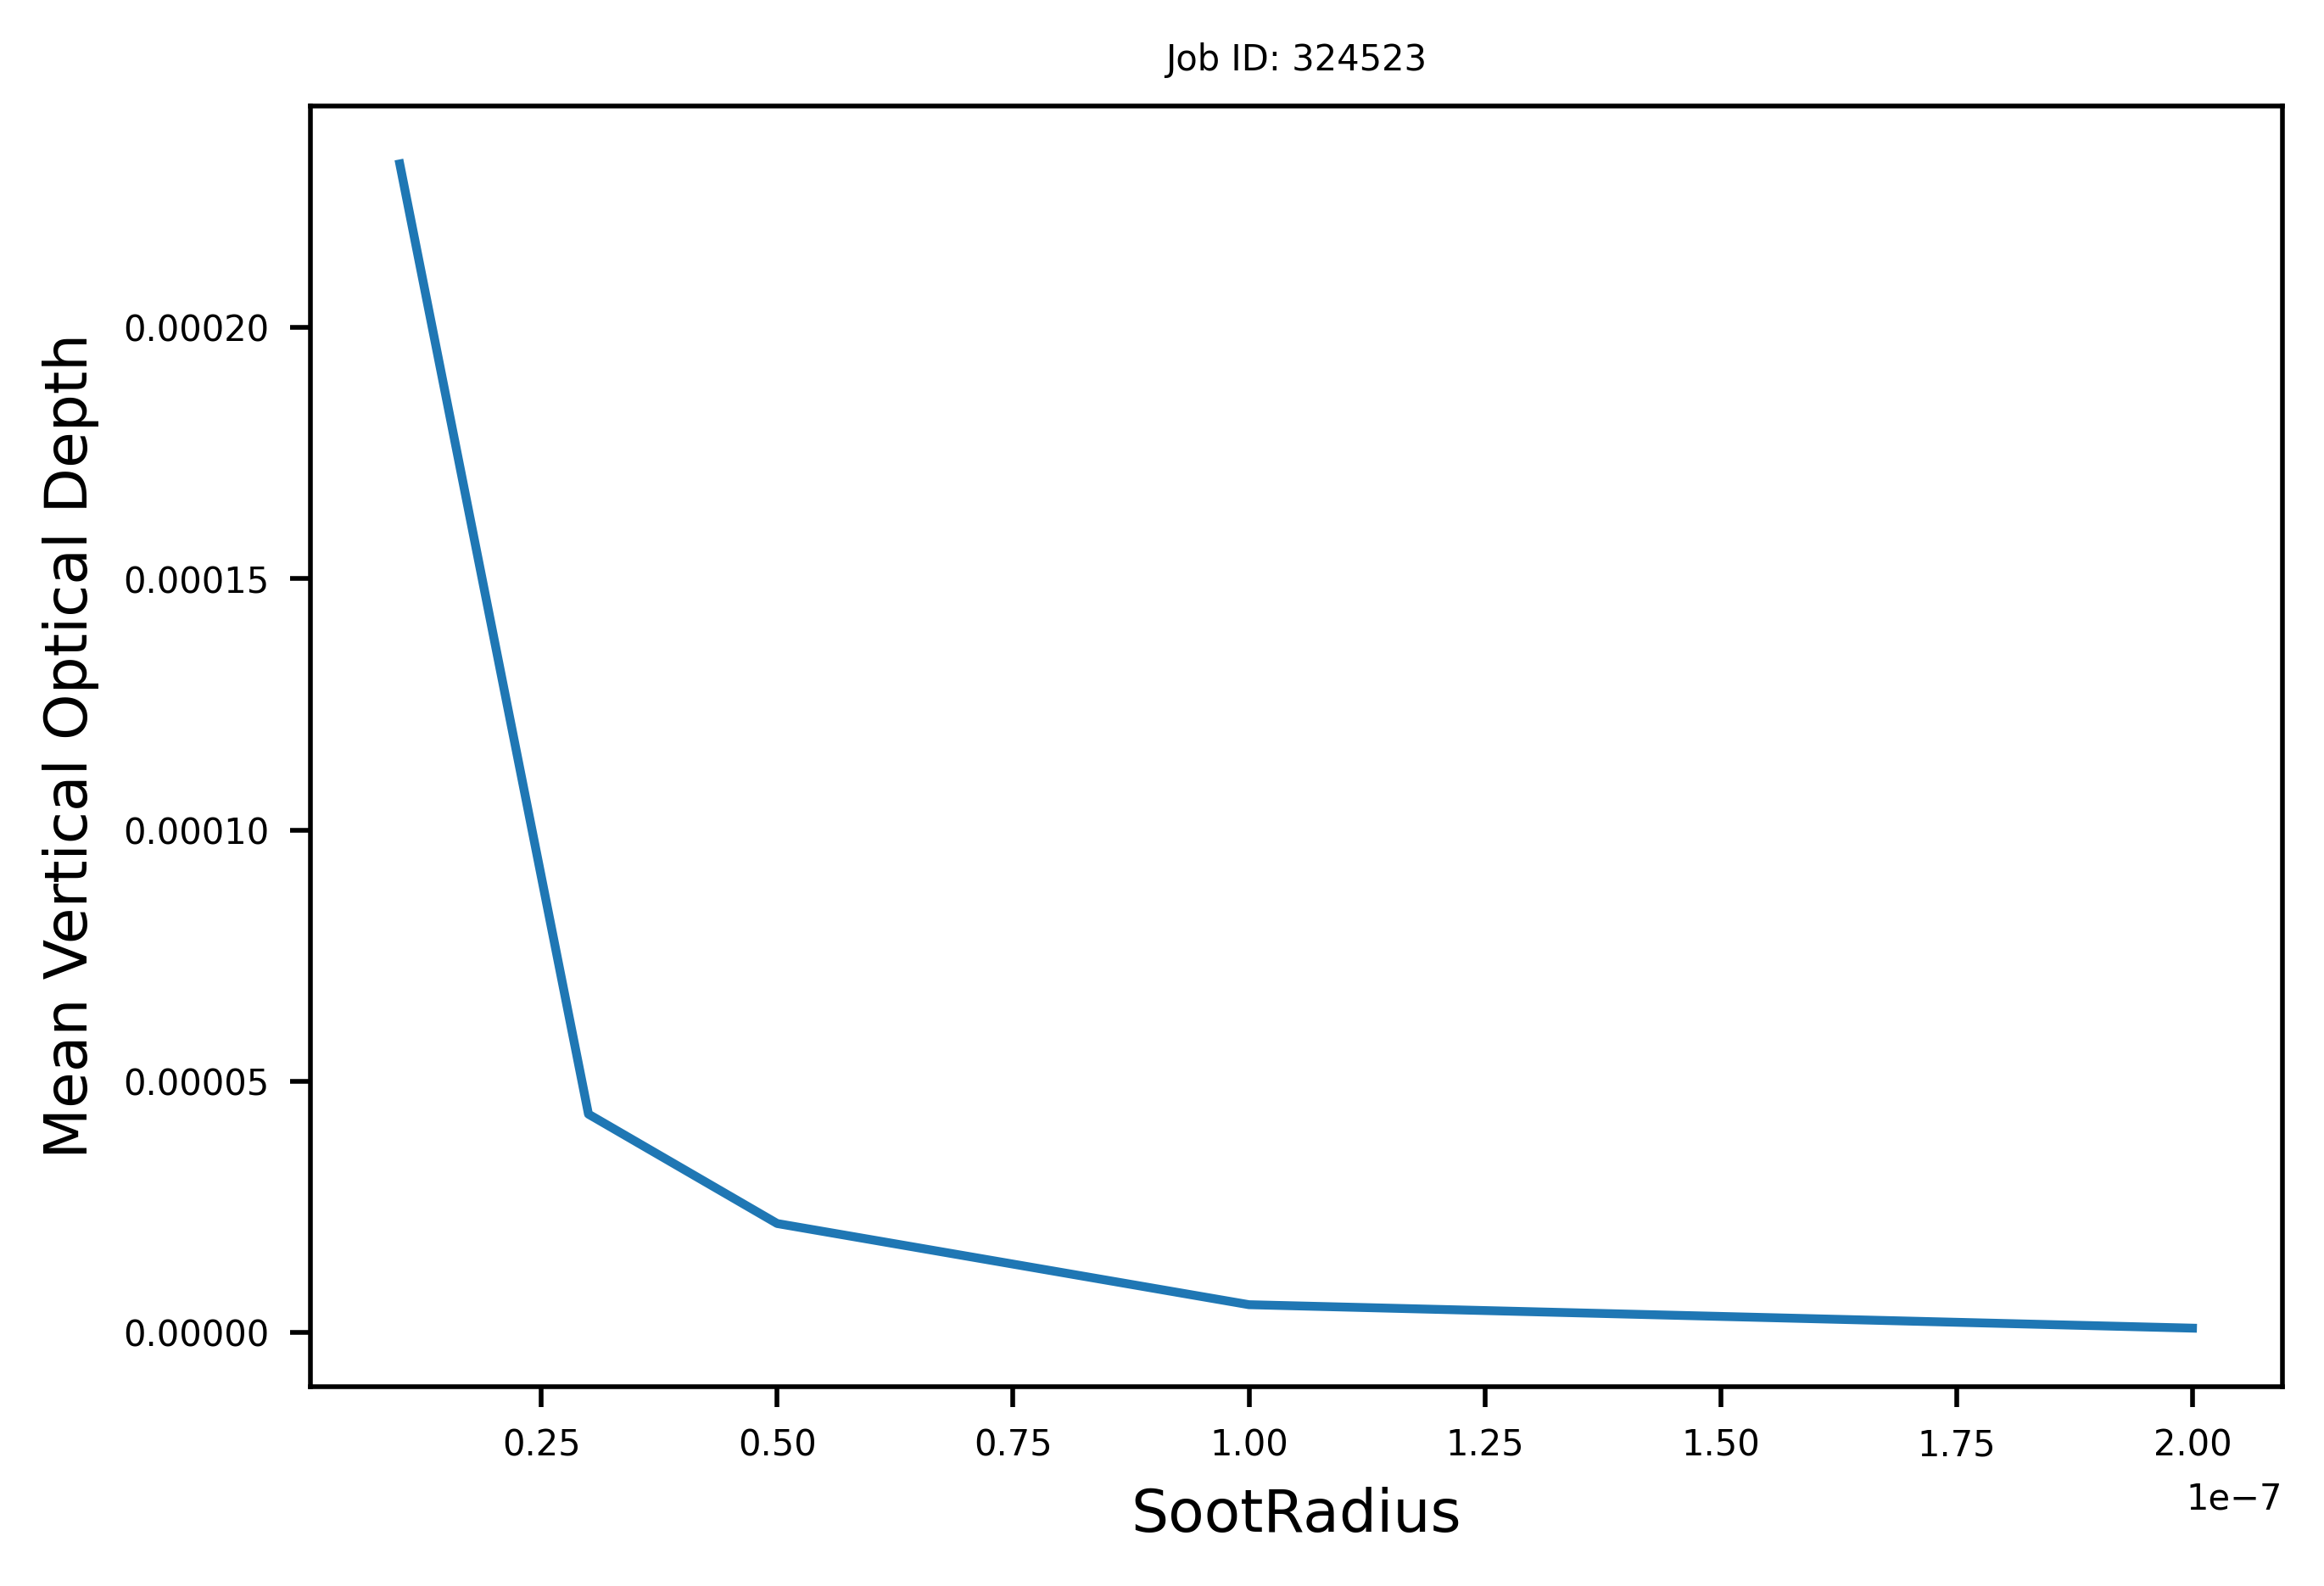

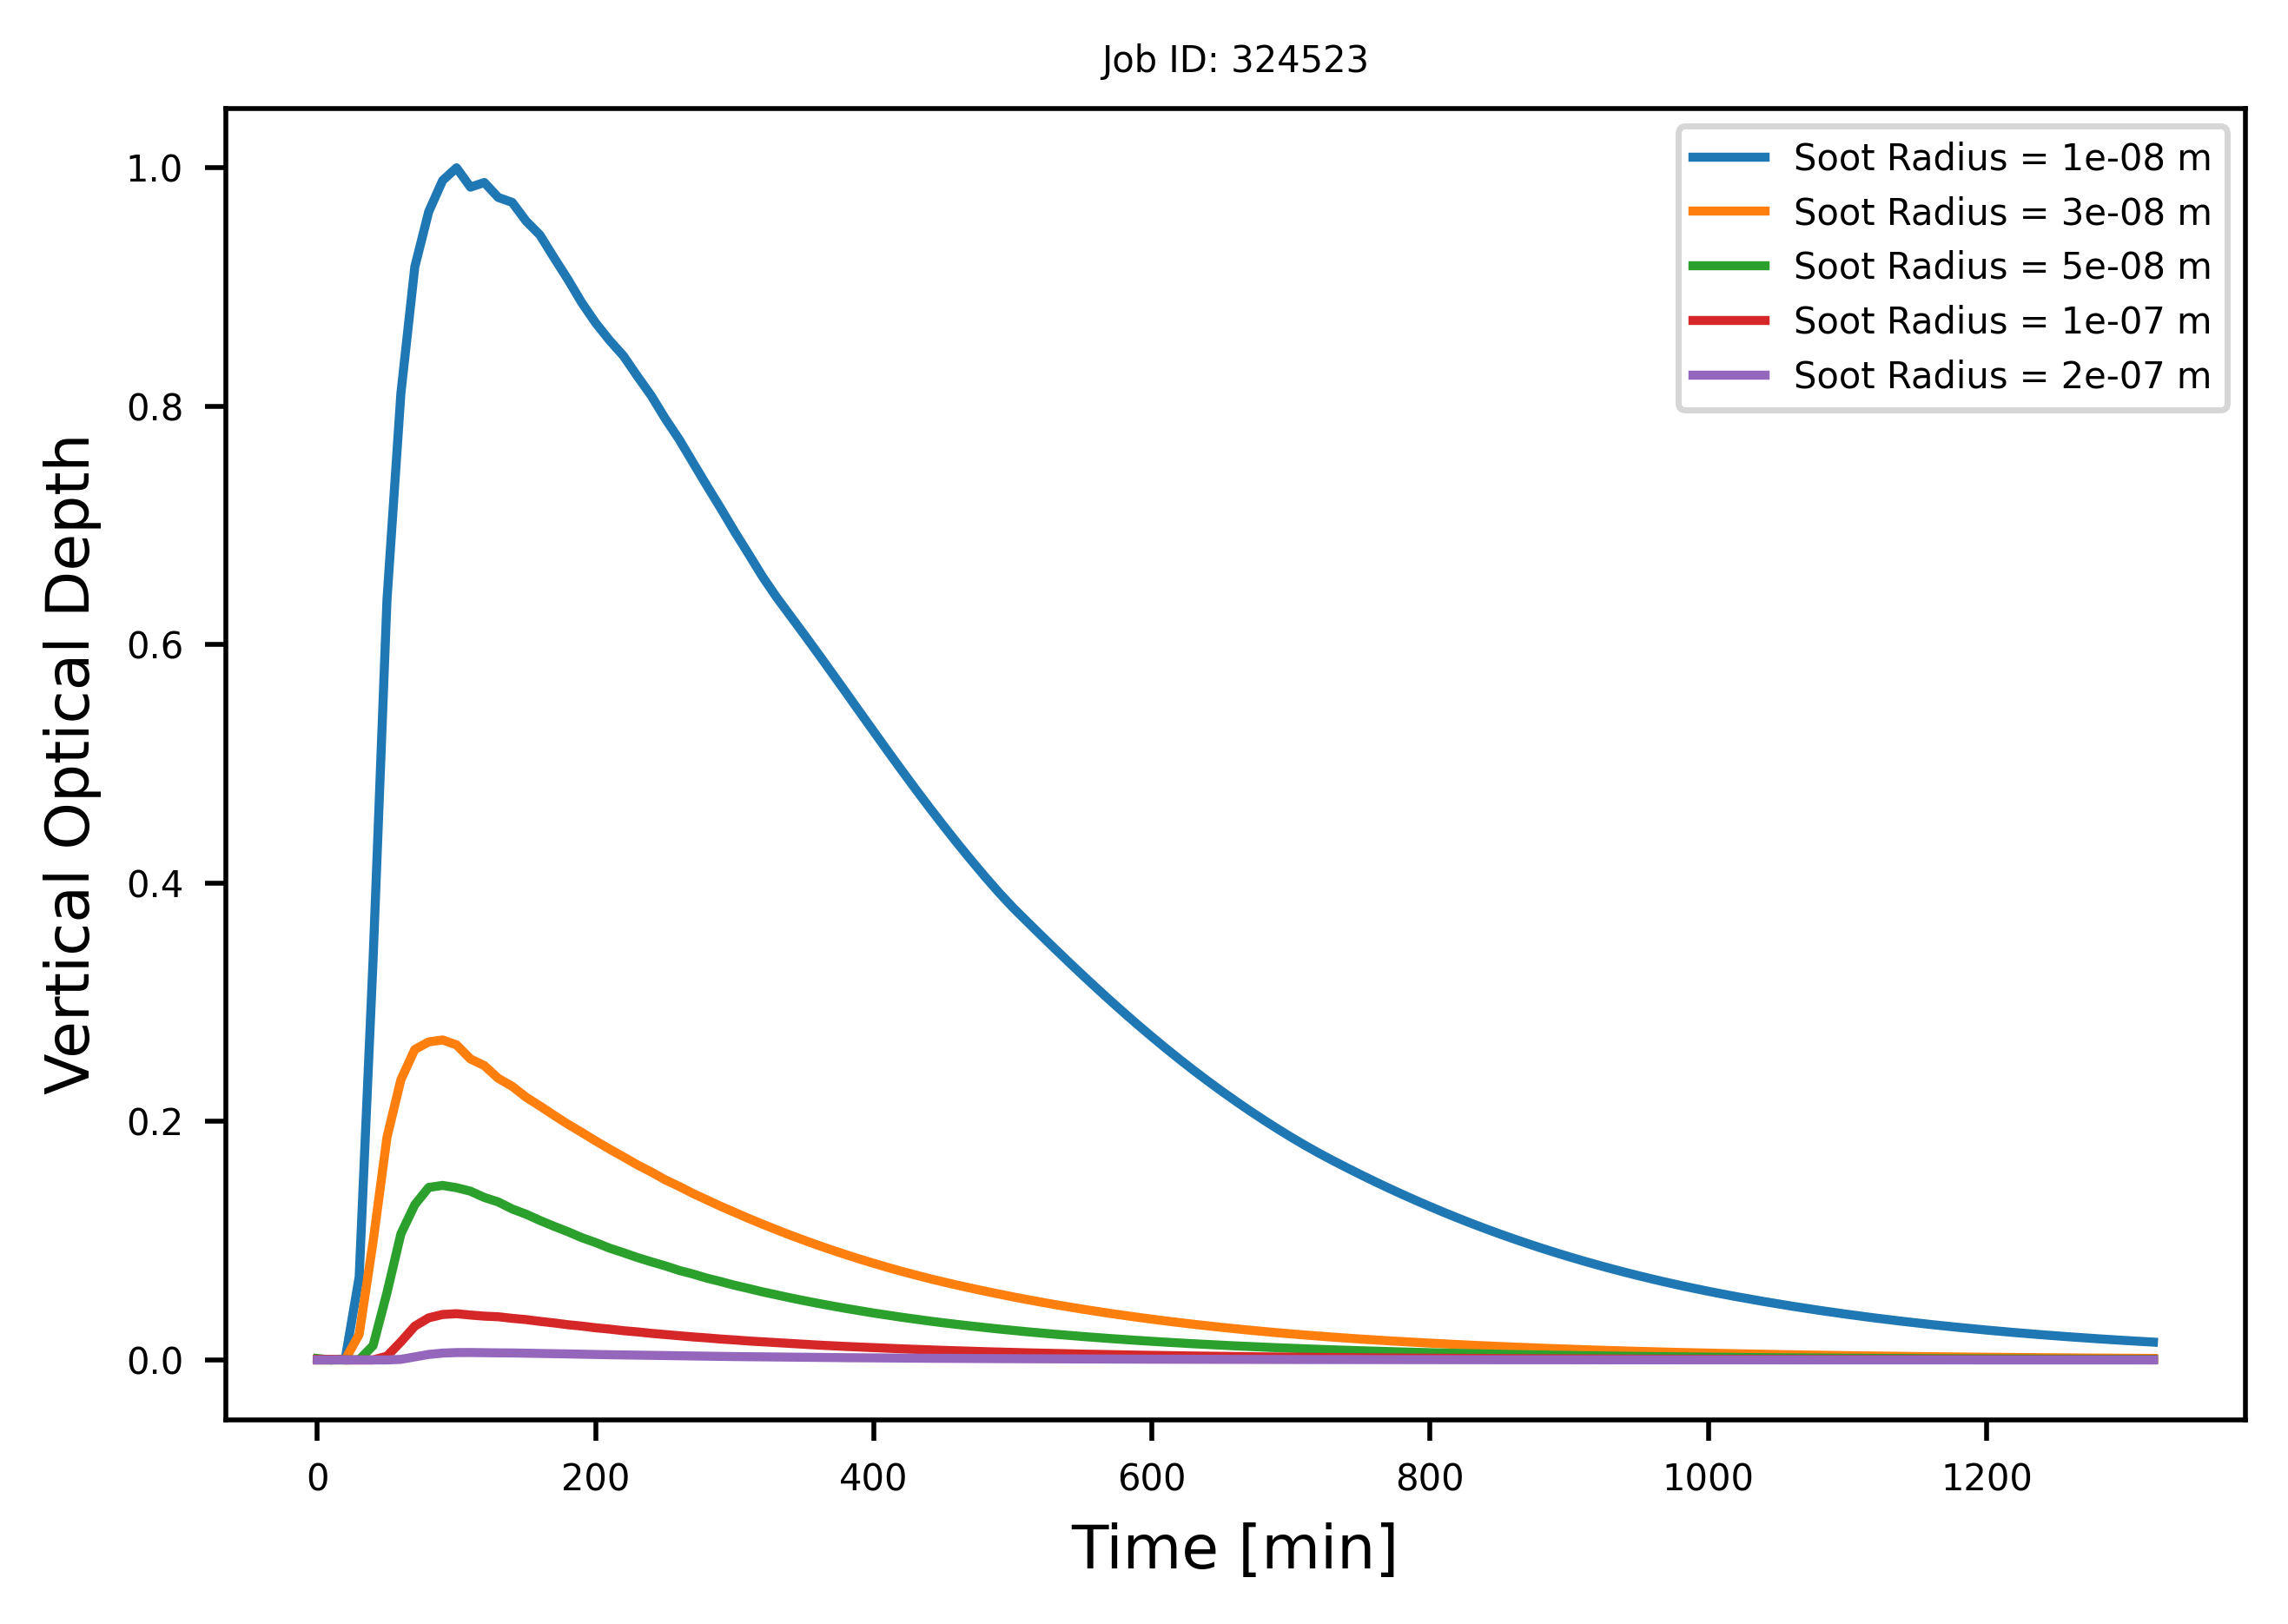

In [11]:
#Plotting for improperly sorted results

fig, axes = plt.subplots(dpi=500)
axes.plot(soot_radius, VOD_case_avg)
axes.set_xlabel(variable)
axes.set_ylabel("Mean Vertical Optical Depth")
axes.set_title("Job ID: "+JOB_ID)
fig.savefig('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/'+variable+'_vs_OD')

fig2, axes2 = plt.subplots(dpi=500)
split_result_array = int(t_len/5)

VOD_cases = np.zeros((cases,split_result_array))
for j in range(cases):
    VOD_cases[j,:] = VOD[j*split_result_array :(j+1)*split_result_array]
    axes2.plot(t[0:133], VOD[j*split_result_array :(j+1)*split_result_array], label='Soot Radius = '+str(soot_radius[j])+' m')

%store VOD_cases
%store t

axes2.legend()
axes2.set_title("Job ID: "+JOB_ID)
#axes2.set_xlim(0,100)

axes2.set_xlabel("Time [min]")
axes2.set_ylabel("Vertical Optical Depth")
# fig2.savefig('/home/chinahg/GCresearch/APCEMM/rundirs/SampleRunDir/slurm/'+variable+'-'+JOB_ID+'/soot_time_vs_OD')